# ELG7186 - Winter 2022 - Assignment 3
## Due: <strong>Monday March 21<sup>st</sup> 2022 -- 11:59pm</strong>

In this assignment, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You must use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


In [154]:
#import libraries
import os
import cv2
from PIL import Image
from tensorflow import keras
import tensorflow
import keras 
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D , Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Prepare your dataset here
#function for read images
def read_image(paths_data):
    x=[]
    y=[]
    for file in os.listdir(paths_data):
        file_name = re.findall("\d", file)
        a=''.join(file_name)
        path_data=os.path.join(paths_data,file)
        for image in os.listdir(path_data):
            image=cv2.imread(os.path.join(path_data,image))
            resize_image=cv2.resize(image, (64, 64))
            x.append(resize_image)
            y.append(a)
    return np.array(x),y

In [19]:
#paths of images
paths_data_train="D:/studies/depi/ottawa/second_term/computer vision/ass_doctor/ass3/training"
paths_data_test="D:/studies/depi/ottawa/second_term/computer vision/ass_doctor/ass3/testing"

In [20]:
#call function for read images
x_train,y_train=read_image(paths_data_train)
x_test,y_test=read_image(paths_data_test)

In [21]:
len(x_train)

900

In [22]:
#labl ecoding
y_train=LabelEncoder().fit_transform(y_train)
y_test=LabelEncoder().fit_transform(y_test)

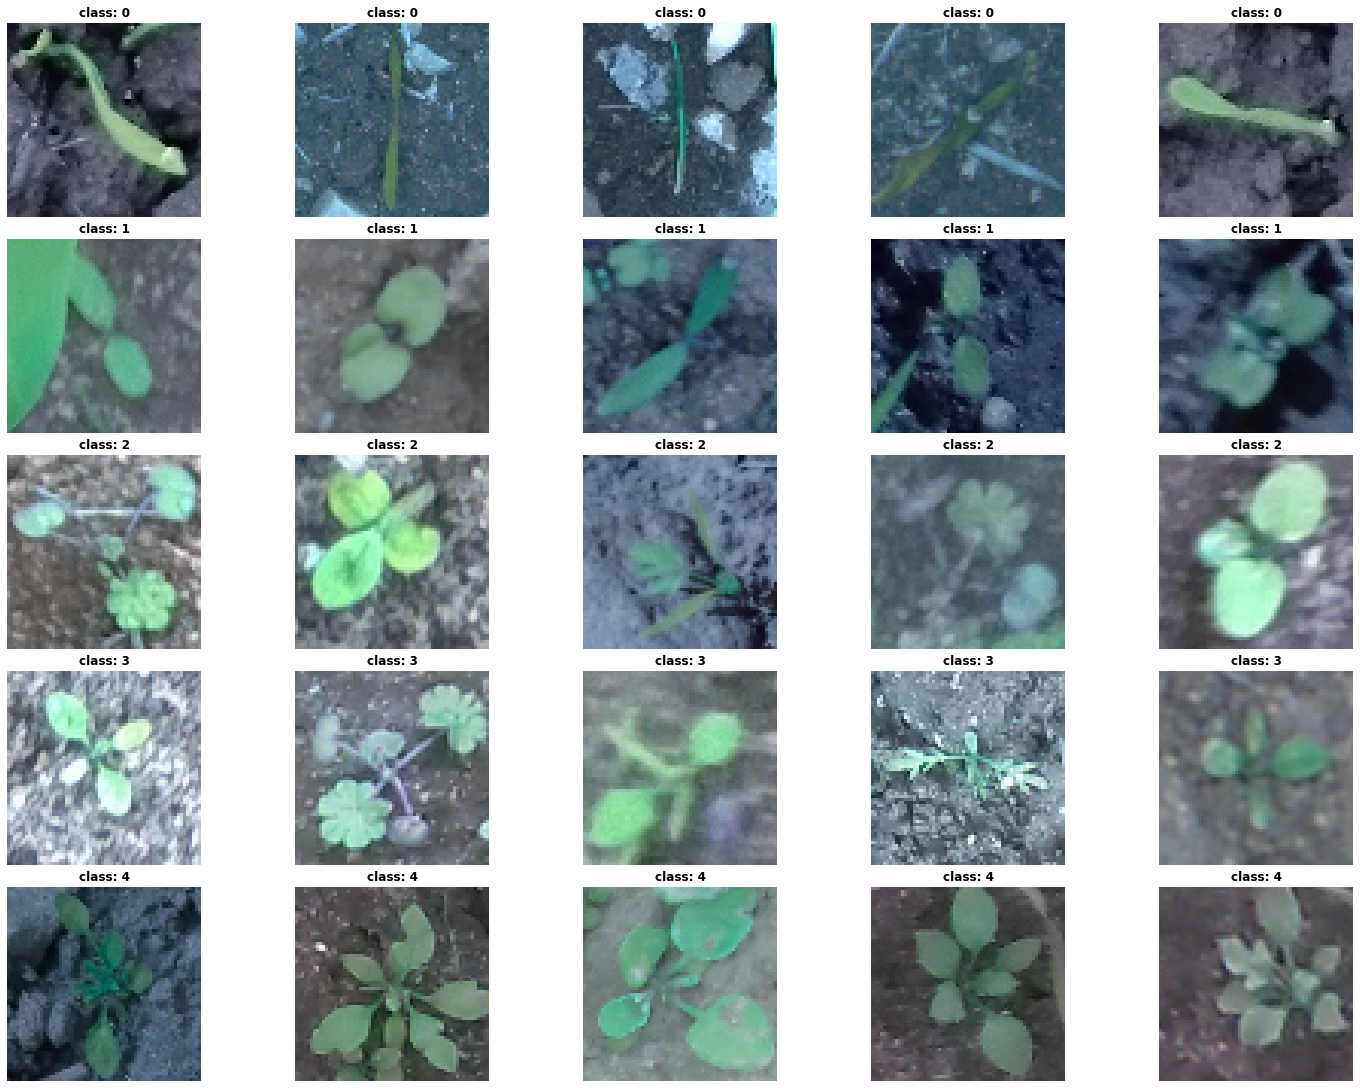

In [8]:
#visualize five samples for each class
fig, axs = plt.subplots(5,5,figsize=(20,15),constrained_layout=True)
for x in np.unique(y_train):
    count=0
    for y in range(0,len(y_train)):
        if count>=5:
            break
        if x == y_train[y]:
            axs[x,count].set_axis_off()
            axs[x,count].imshow(x_train[y], cmap=plt.cm.gray,interpolation="nearest")
            axs[x,count].set_title("class: %i" % x,fontweight ="bold")
            count+=1

In [23]:
x_train,x_val, y_train,y_val=train_test_split(x_train,y_train, test_size=0.1,random_state=0)

In [24]:
len(x_train)

810

In [25]:
#using catogorical from keras
y__train =to_categorical(y_train,5)
y__test =to_categorical(y_test,5)
y__val=to_categorical(y_val,5)

In [26]:
y__val.shape

(90, 5)

## Part 1a. Transfer Learning - Classification Network (3 Marks)
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


In [27]:
# Write your code here
# vgg16
base_model_vgg=VGG16(weights='imagenet',include_top=False,input_shape=(64, 64, 3))
base_model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [28]:
# Using the first 2 blocks of VGG-16
vgg_model=models.Model(base_model_vgg.input, base_model_vgg.layers[6].output)
for layer in vgg_model.layers:
    layer.trainable = False
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [79]:
# adding conv26 and maxpooling
vgg_model1=vgg_model.output
vgg_model1=Conv2D(64,(3, 3),padding="same",activation="relu")(vgg_model1)
#vgg_model1=MaxPooling2D()(vgg_model1)
vgg_model1=Conv2D(64,(3, 3),padding="same",activation="relu")(vgg_model1)
vgg_model1=MaxPooling2D(pool_size=(2, 2))(vgg_model1)
vgg_model1=Conv2D(32,(3, 3),padding="same",activation="relu")(vgg_model1)
vgg_model1=Conv2D(32,(3, 3),padding="same",activation="relu")(vgg_model1)
vgg_model1=MaxPooling2D(pool_size=(2, 2))(vgg_model1)
#vgg_model1=Conv2D(64,(3, 3),padding="same",activation="relu")(vgg_model1)
#vgg_model1=MaxPooling2D()(vgg_model1)
vgg_model1=Flatten()(vgg_model1)
#vgg_model1=Dense(1024, activation='relu')(vgg_model1)
vgg_model1=Dense(5, activation='softmax')(vgg_model1)
vgg__model=models.Model(inputs=vgg_model.input,outputs=vgg_model1)
vgg__model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [80]:
#compile model
#sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.0008)
#vgg__model.compile(loss='categorical_crossentropy', 
#                           optimizer=sgd, 
#                           metrics=['accuracy'])
vgg__model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#fit model
result_vgg=vgg__model.fit(x_train,y__train,epochs=40,validation_data=(x_val,y__val),batch_size=32)

Epoch 1/40
26/26 [==============================] - 11s 385ms/step - loss: 112.2363 - accuracy: 0.2037 - val_loss: 13.7531 - val_accuracy: 0.2000
Epoch 2/40
26/26 [==============================] - 11s 414ms/step - loss: 8.9779 - accuracy: 0.2198 - val_loss: 6.2747 - val_accuracy: 0.2222
Epoch 3/40
26/26 [==============================] - 12s 466ms/step - loss: 4.4267 - accuracy: 0.2259 - val_loss: 3.8750 - val_accuracy: 0.2000
Epoch 4/40
26/26 [==============================] - 12s 463ms/step - loss: 2.2063 - accuracy: 0.2556 - val_loss: 1.7191 - val_accuracy: 0.2333
Epoch 5/40
26/26 [==============================] - 12s 463ms/step - loss: 1.6539 - accuracy: 0.2086 - val_loss: 1.6074 - val_accuracy: 0.2000
Epoch 6/40
26/26 [==============================] - 12s 467ms/step - loss: 1.6155 - accuracy: 0.2247 - val_loss: 1.6116 - val_accuracy: 0.2000
Epoch 7/40
26/26 [==============================] - 13s 490ms/step - loss: 1.5948 - accuracy: 0.2309 - val_loss: 1.5973 - val_accuracy: 0.1

Text(0, 0.5, 'Losses')

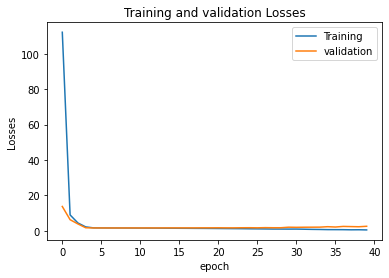

In [81]:
#plot loss in traning and testing 
plt.plot(result_vgg.history['loss'])
plt.plot(result_vgg.history['val_loss'])
plt.legend(['Training', 'validation'])
plt.title('Training and validation Losses')
plt.xlabel('epoch')
plt.ylabel('Losses')

Text(0, 0.5, 'accuracy')

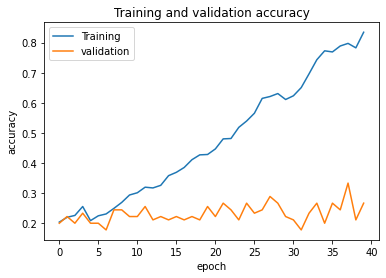

In [82]:
#plot accuracy in traning and testing 
plt.plot(result_vgg.history['accuracy'])
plt.plot(result_vgg.history['val_accuracy'])
plt.legend(['Training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [83]:
#function for confusion matrix
def con_fusion_matrix(label,pred):
    cm = confusion_matrix(label, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

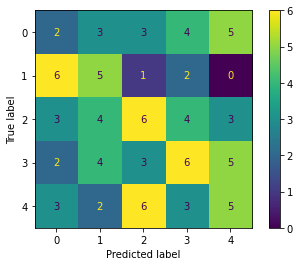

In [84]:
#predit validation data and plot confusion matrix
y_pred=vgg__model.predict(x_val)
y__pred=np.argmax(y_pred, axis=1)
label=np.argmax(y__val,axis=1)
con_fusion_matrix(label,y__pred)

In [85]:
#accuracy for model on validation data
print("accuracy for Classification_validation data",accuracy_score(label,y__pred))
val_score = vgg__model.evaluate(x_val, y__val,verbose=1)
print('val loss:', val_score[0])
print('val accuracy:', val_score[1])

accuracy for Classification_validation data 0.26666666666666666
3/3 [==============================] - 1s 258ms/step - loss: 2.5551 - accuracy: 0.2667
val loss: 2.555068254470825
val accuracy: 0.2666666805744171


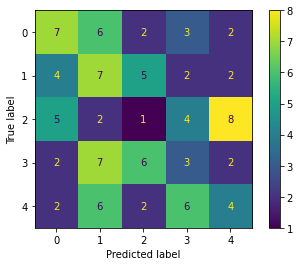

In [86]:
#predit test data and plot confusion matrix
y_pred_test=vgg__model.predict(x_test)
y__pred_test=np.argmax(y_pred_test, axis=1)
label_test=np.argmax(y__test,axis=1)
con_fusion_matrix(label_test,y__pred_test)

In [87]:
#accuracy for model on testing data
print("accuracy for Classification_testing data",accuracy_score(label_test,y__pred_test))
test_score = vgg__model.evaluate(x_test, y__test,verbose=1)
print('test loss:', test_score[0])
print('test accuracy:', test_score[1])

accuracy for Classification_testing data 0.22
4/4 [==============================] - 1s 208ms/step - loss: 2.7264 - accuracy: 0.2200
test loss: 2.72640323638916
test accuracy: 0.2199999988079071


## Part 1b. Transfer Learning - Regression Reformulation (3 Marks)

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

In [37]:
#Write your code here
#convert label to float type for regression
#def label_float(data):
#    data_label=[]
#    for i in (data):
#        data_label.append(float(i))
#    return data_label

In [38]:
#call function for convert to float
#y___train=label_float(y_train)
#y___val=label_float(y_val)
#y___test=label_float(y_test)

In [89]:
# vgg16
base_model_vgg_r=VGG16(weights='imagenet',include_top=False,input_shape=(64, 64, 3))
base_model_vgg_r.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [90]:
# Using the first 2 blocks of VGG-16
vgg_model_r=models.Model(base_model_vgg_r.input, base_model_vgg_r.layers[6].output)
for layer in vgg_model_r.layers:
    layer.trainable = False
vgg_model_r.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [93]:
# adding conv26 and maxpooling
vgg_model1_r=vgg_model_r.output
vgg_model1_r=Conv2D(64,(3, 3),padding="same",activation="relu")(vgg_model1_r)
#vgg_model1_r=MaxPooling2D()(vgg_model1_r)
vgg_model1_r=Conv2D(64,(3, 3),padding="same",activation="relu")(vgg_model1_r)
vgg_model1_r=MaxPooling2D(pool_size=(2, 2))(vgg_model1_r)
vgg_model1_r=Conv2D(32,(3, 3),padding="same",activation="relu")(vgg_model1_r)
vgg_model1_r=Conv2D(32,(3, 3),padding="same",activation="relu")(vgg_model1_r)
vgg_model1_r=MaxPooling2D(pool_size=(2, 2))(vgg_model1_r)
#vgg_model1_r=MaxPooling2D()(vgg_model1_r)
vgg_model1_r=Flatten()(vgg_model1_r)
#vgg_model1_r=Dense(256, activation='relu')(vgg_model1_r)
vgg_model1_r=Dense(1, activation='linear')(vgg_model1_r)
vgg_model1_r=models.Model(inputs=vgg_model_r.input,outputs=vgg_model1_r)
vgg_model1_r.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [95]:
#compile model
vgg_model1_r.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
#fit model
result_vgg_r=vgg_model1_r.fit(x_train, np.array(y_train),epochs=40,validation_data=(x_val, np.array(y_val)),batch_size=32)

Epoch 1/40
26/26 [==============================] - 11s 381ms/step - loss: 1379.5759 - accuracy: 0.2222 - val_loss: 660.3945 - val_accuracy: 0.1333
Epoch 2/40
26/26 [==============================] - 12s 448ms/step - loss: 240.0575 - accuracy: 0.2037 - val_loss: 235.7490 - val_accuracy: 0.1444
Epoch 3/40
26/26 [==============================] - 12s 460ms/step - loss: 86.5887 - accuracy: 0.2074 - val_loss: 160.4073 - val_accuracy: 0.1444
Epoch 4/40
26/26 [==============================] - 12s 473ms/step - loss: 49.2049 - accuracy: 0.2185 - val_loss: 126.3652 - val_accuracy: 0.1444
Epoch 5/40
26/26 [==============================] - 12s 461ms/step - loss: 30.9991 - accuracy: 0.2173 - val_loss: 108.7489 - val_accuracy: 0.1556
Epoch 6/40
26/26 [==============================] - 12s 463ms/step - loss: 22.5386 - accuracy: 0.2235 - val_loss: 100.5928 - val_accuracy: 0.1444
Epoch 7/40
26/26 [==============================] - 12s 466ms/step - loss: 15.0306 - accuracy: 0.2235 - val_loss: 91.8469

Text(0, 0.5, 'Losses')

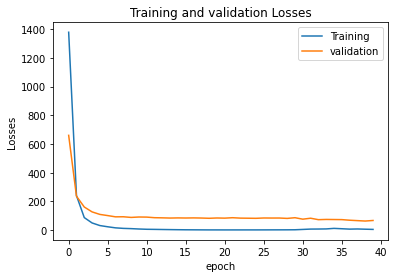

In [96]:
#plot loss in traning and testing 
plt.plot(result_vgg_r.history['loss'])
plt.plot(result_vgg_r.history['val_loss'])
plt.legend(['Training', 'validation'])
plt.title('Training and validation Losses')
plt.xlabel('epoch')
plt.ylabel('Losses')

Text(0, 0.5, 'accuracy')

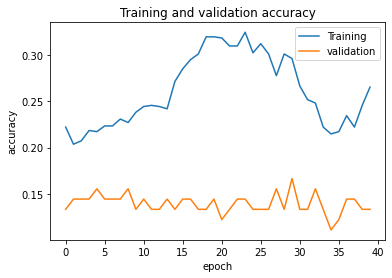

In [97]:
#plot accuracy in traning and testing 
plt.plot(result_vgg_r.history['accuracy'])
plt.plot(result_vgg_r.history['val_accuracy'])
plt.legend(['Training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [98]:
#evulate model on training data
train_score_r=vgg_model1_r.evaluate(x_train,np.array(y_train),verbose=1)
print('train_loss:', train_score_r[0])
print('train_accuracy:', train_score_r[1])
#evulate model on validation data
vald_score_r=vgg_model1_r.evaluate(x_val,np.array(y_val),verbose=1)
print('vald_loss:', vald_score_r[0])
print('vald_accuracy:', vald_score_r[1])
#evulate model on testing data
test_score_r=vgg_model1_r.evaluate(x_test,np.array(y_test),verbose=1)
print('test_loss:', test_score_r[0])
print('test_accuracy:', test_score_r[1])

26/26 [==============================] - 7s 277ms/step - loss: 3.0621 - accuracy: 0.2506
train_loss: 3.0621466636657715
train_accuracy: 0.25061729550361633
3/3 [==============================] - 1s 256ms/step - loss: 66.4271 - accuracy: 0.1333
vald_loss: 66.4271469116211
vald_accuracy: 0.13333334028720856
4/4 [==============================] - 1s 211ms/step - loss: 50.1690 - accuracy: 0.2200
test_loss: 50.169036865234375
test_accuracy: 0.2199999988079071


In [99]:
#pred data validation and testing
def model_pred(model,data):
    pred = model.predict(data)
    return pred

In [100]:
#call function fro prediction
pred_val=model_pred(vgg_model1_r,x_val)
pred_test=model_pred(vgg_model1_r,x_test)

In [102]:
#round prediction for confucison matrix
def round_pred(pred):
    for i in range(len(pred)):
      if pred[i]<=0:
        pred[i]=0
      elif pred[i]>=4:
        pred[i]=4
      else:
        pred[i]=np.round(pred[i])
    pred=pred.astype(int)
    return pred

In [103]:
#call function
pred_val_ro=round_pred(pred_val)
pred_test_ro=round_pred(pred_test)

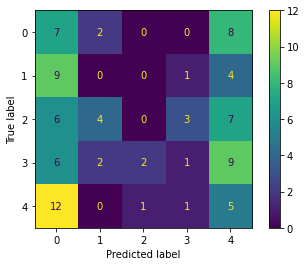

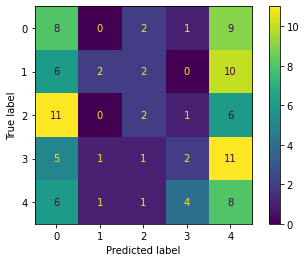

In [104]:
#cal function for confusion matrix
con_fusion_matrix(y_val,pred_val_ro)
con_fusion_matrix(y_test,pred_test_ro)

Write your discussion here.

# discussion

overfitting is occurring in model for classification and underfitting is occuring in model for regression because of size of the data is very small.the model of classification and regression give less accuracy in validation data and more accuracy in training data but the model of classification give more accuracy from regression in validation data so i try improve the model of calssificatio in the next step to reduce the overfitting. 

# note

in the first,I choice size of image 64*64*3. Then I apply moore architecture of model (use one conv with fully connected,two conv and three conv with fully connected) so I apply the best architecture(four conv then flatten then output layer) in all part1 and part2 give me best accuracy. I can use early stopping to prevent overfitting but i would not prefere using it.In regression use loss='mean_squared_error'and metrics= 'accuracy' because of plot accuracy but I can use metrics= 'mse'.

## Part 2. Improve your Model (4 Marks)

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.
 

### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

# step 1

In [106]:
# Write your code here
# vgg16
base_model_vgg_im=VGG16(weights='imagenet',include_top=False,input_shape=(64, 64, 3))
base_model_vgg_im.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [107]:
# Using the first 2 blocks of VGG-16
vgg_model_im=models.Model(base_model_vgg_im.input, base_model_vgg_im.layers[6].output)
for layer in vgg_model_im.layers:
    layer.trainable = False
vgg_model_im.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [186]:
# adding conv26, maxpooling, Batch Normalization and Dropout
vgg_model1_im=vgg_model_im.output
vgg_model1_im=Conv2D(64,(3, 3),padding="same",activation="relu")(vgg_model1_im)
#vgg_model1_im=BatchNormalization()(vgg_model1_im)
#vgg_model1_im=BatchNormalization()(vgg_model1_im)
#vgg_model1_im=Dropout(0.6)(vgg_model1_im)
vgg_model1_im=Conv2D(64,(3, 3),padding="same",activation="relu")(vgg_model1_im)
vgg_model1_im=BatchNormalization()(vgg_model1_im)
vgg_model1_im=BatchNormalization()(vgg_model1_im)
vgg_model1_im=Dropout(0.6)(vgg_model1_im)
vgg_model1_im=MaxPooling2D(pool_size=(2, 2))(vgg_model1_im)
vgg_model1_im=Conv2D(32,(3, 3),padding="same",activation="relu")(vgg_model1_im)
#vgg_model1_im=BatchNormalization()(vgg_model1_im)
#vgg_model1_im=BatchNormalization()(vgg_model1_im)
#vgg_model1_im=Dropout(0.6)(vgg_model1_im)
vgg_model1_im=Conv2D(32,(3, 3),padding="same",activation="relu")(vgg_model1_im)
vgg_model1_im=BatchNormalization()(vgg_model1_im)
vgg_model1_im=BatchNormalization()(vgg_model1_im)
vgg_model1_im=Dropout(0.6)(vgg_model1_im)
vgg_model1_im=MaxPooling2D(pool_size=(2, 2))(vgg_model1_im)
vgg_model1_im=BatchNormalization()(vgg_model1_im)
vgg_model1_im=BatchNormalization()(vgg_model1_im)
vgg_model1_im=Flatten()(vgg_model1_im)
vgg_model1_im=BatchNormalization()(vgg_model1_im)
vgg_model1_im=BatchNormalization()(vgg_model1_im)
vgg_model1_im=Dropout(0.6)(vgg_model1_im)
vgg_model1_im=Dense(5, activation='softmax')(vgg_model1_im)
vgg__model_im=models.Model(inputs=vgg_model_im.input,outputs=vgg_model1_im)
vgg__model_im.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [187]:
#compile model
vgg__model_im.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#fit model
result_vgg_im=vgg__model_im.fit(x_train,y__train,epochs=40,validation_data=(x_val,y__val),batch_size=32)

Epoch 1/40
26/26 [==============================] - 49s 2s/step - loss: 2.7427 - accuracy: 0.2062 - val_loss: 6.3450 - val_accuracy: 0.2222
Epoch 2/40
26/26 [==============================] - 39s 1s/step - loss: 2.6569 - accuracy: 0.2247 - val_loss: 2.5325 - val_accuracy: 0.2333
Epoch 3/40
26/26 [==============================] - 38s 1s/step - loss: 2.5191 - accuracy: 0.2247 - val_loss: 2.6650 - val_accuracy: 0.2222
Epoch 4/40
26/26 [==============================] - 40s 2s/step - loss: 2.5488 - accuracy: 0.2235 - val_loss: 1.7166 - val_accuracy: 0.2778
Epoch 5/40
26/26 [==============================] - 39s 2s/step - loss: 2.3619 - accuracy: 0.2346 - val_loss: 1.7301 - val_accuracy: 0.2111
Epoch 6/40
26/26 [==============================] - 40s 2s/step - loss: 2.3119 - accuracy: 0.2494 - val_loss: 1.6066 - val_accuracy: 0.2556
Epoch 7/40
26/26 [==============================] - 46s 2s/step - loss: 2.0999 - accuracy: 0.2556 - val_loss: 1.8815 - val_accuracy: 0.2556
Epoch 8/40
26/26 [==

Text(0, 0.5, 'Losses')

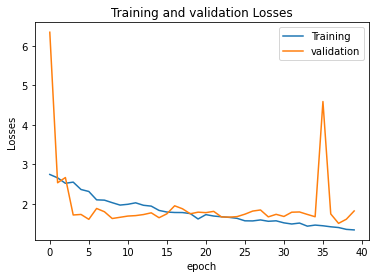

In [188]:
#plot loss in traning and testing 
plt.plot(result_vgg_im.history['loss'])
plt.plot(result_vgg_im.history['val_loss'])
plt.legend(['Training', 'validation'])
plt.title('Training and validation Losses')
plt.xlabel('epoch')
plt.ylabel('Losses')

Text(0, 0.5, 'accuracy')

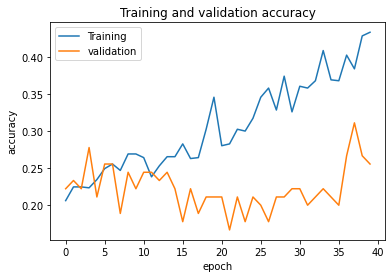

In [189]:
#plot accuracy in traning and testing 
plt.plot(result_vgg_im.history['accuracy'])
plt.plot(result_vgg_im.history['val_accuracy'])
plt.legend(['Training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

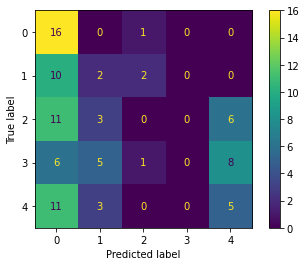

In [190]:
#predit validation data and plot confusion matrix
y_pred_im=vgg__model_im.predict(x_val)
y__pred_im=np.argmax(y_pred_im, axis=1)
label_im=np.argmax(y__val,axis=1)
con_fusion_matrix(label_im,y__pred_im)

In [191]:
#accuracy for model on validation data
print("accuracy for Classification_validation data",accuracy_score(label_im,y__pred_im))
val_score_im=vgg__model_im.evaluate(x_val, y__val,verbose=1)
print('val loss:', val_score_im[0])
print('val accuracy:', val_score_im[1])

accuracy for Classification_validation data 0.25555555555555554
3/3 [==============================] - 4s 1s/step - loss: 1.8185 - accuracy: 0.2556
val loss: 1.8184974193572998
val accuracy: 0.25555557012557983


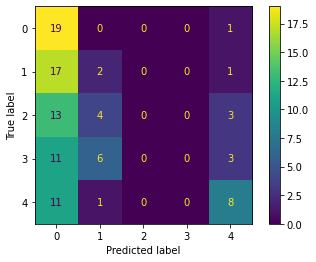

In [192]:
#predit test data and plot confusion matrix
y_pred_test_im=vgg__model_im.predict(x_test)
y__pred_test_im=np.argmax(y_pred_test_im, axis=1)
label_test_im=np.argmax(y__test,axis=1)
con_fusion_matrix(label_test_im,y__pred_test_im)

In [193]:
#accuracy for model on testing data
print("accuracy for Classification_testing data",accuracy_score(label_test_im,y__pred_test_im))
test_score_im=vgg__model_im.evaluate(x_test, y__test,verbose=1)
print('test loss:', test_score_im[0])
print('test accuracy:', test_score_im[1])

accuracy for Classification_testing data 0.29
4/4 [==============================] - 4s 790ms/step - loss: 1.8509 - accuracy: 0.2900
test loss: 1.8508539199829102
test accuracy: 0.28999999165534973


# step 2

In [180]:
#data_augm=ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
#    rescale=1./255,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True)
#data_augm.fit(x_train, augment=True)

In [194]:
#data augmentation 
data_augm=ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.01,horizontal_flip=True,
                           fill_mode='nearest')
data_augm.fit(x_train, augment=True)

In [195]:
#compile model
vgg__model_im.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#fit model
result_vgg_im_aug = vgg__model_im.fit(data_augm.flow(x_train,y__train, batch_size=32),epochs=40,validation_data=(x_val,y__val))

Epoch 1/40
26/26 [==============================] - 50s 2s/step - loss: 1.5283 - accuracy: 0.3753 - val_loss: 2.7591 - val_accuracy: 0.1778
Epoch 2/40
26/26 [==============================] - 41s 2s/step - loss: 1.4552 - accuracy: 0.3864 - val_loss: 1.5779 - val_accuracy: 0.3667
Epoch 3/40
26/26 [==============================] - 43s 2s/step - loss: 1.3698 - accuracy: 0.4259 - val_loss: 1.7710 - val_accuracy: 0.2444
Epoch 4/40
26/26 [==============================] - 46s 2s/step - loss: 1.3697 - accuracy: 0.4160 - val_loss: 1.7065 - val_accuracy: 0.2778
Epoch 5/40
26/26 [==============================] - 40s 2s/step - loss: 1.2976 - accuracy: 0.4593 - val_loss: 2.4025 - val_accuracy: 0.2111
Epoch 6/40
26/26 [==============================] - 44s 2s/step - loss: 1.3943 - accuracy: 0.4235 - val_loss: 1.7431 - val_accuracy: 0.2889
Epoch 7/40
26/26 [==============================] - 43s 2s/step - loss: 1.3392 - accuracy: 0.4469 - val_loss: 3.1892 - val_accuracy: 0.2333
Epoch 8/40
26/26 [==

Text(0, 0.5, 'Losses')

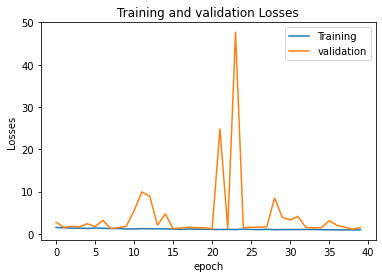

In [196]:
#plot loss in traning and testing 
plt.plot(result_vgg_im_aug .history['loss'])
plt.plot(result_vgg_im_aug .history['val_loss'])
plt.legend(['Training', 'validation'])
plt.title('Training and validation Losses')
plt.xlabel('epoch')
plt.ylabel('Losses')

Text(0, 0.5, 'accuracy')

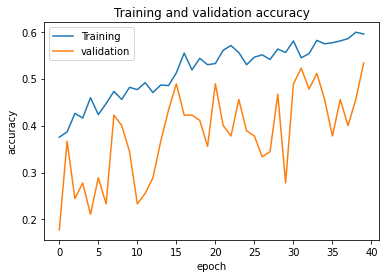

In [197]:
#plot accuracy in traning and testing 
plt.plot(result_vgg_im_aug.history['accuracy'])
plt.plot(result_vgg_im_aug.history['val_accuracy'])
plt.legend(['Training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

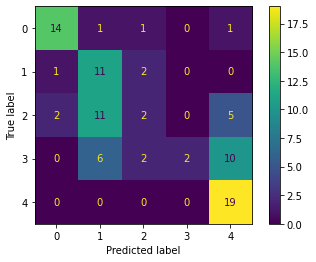

In [199]:
#predit validation data and plot confusion matrix
y_pred_im_au=vgg__model_im.predict(x_val)
y__pred_im_au=np.argmax(y_pred_im_au, axis=1)
label_im_au=np.argmax(y__val,axis=1)
con_fusion_matrix(label_im_au,y__pred_im_au)

In [200]:
#accuracy for model on validation data
print("accuracy for Classification_validation data",accuracy_score(label_im_au,y__pred_im_au))
val_score_im_au=vgg__model_im.evaluate(x_val, y__val,verbose=1)
print('val loss:', val_score_im_au[0])
print('val accuracy:', val_score_im_au[1])

accuracy for Classification_validation data 0.5333333333333333
3/3 [==============================] - 5s 1s/step - loss: 1.4903 - accuracy: 0.5333
val loss: 1.4902814626693726
val accuracy: 0.5333333611488342


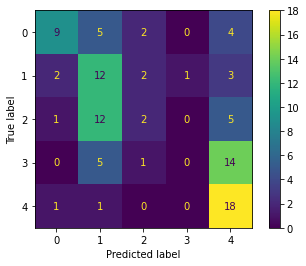

In [201]:
#predit test data and plot confusion matrix
y_pred_test_im_au=vgg__model_im.predict(x_test)
y__pred_test_im_au=np.argmax(y_pred_test_im_au, axis=1)
label_test_im_au=np.argmax(y__test,axis=1)
con_fusion_matrix(label_test_im_au,y__pred_test_im_au)

In [202]:
#accuracy for model on testing data
print("accuracy for Classification_testing data",accuracy_score(label_test_im_au,y__pred_test_im_au))
test_score_im_au=vgg__model_im.evaluate(x_test, y__test,verbose=1)
print('test loss:', test_score_im_au[0])
print('test accuracy:', test_score_im_au[1])

accuracy for Classification_testing data 0.41
4/4 [==============================] - 4s 905ms/step - loss: 2.9052 - accuracy: 0.4100
test loss: 2.9052224159240723
test accuracy: 0.4099999964237213


Write your discussion here.

# discussion

I apply Batchnormalization and dropout to reduce overfitting in the model of classification in part 1.overfitting is reduced (very small overfitting) but the accuracy of model is very small. then apply data augmentation on the training data and fit model in part2. I obtain that overfitting is more reduced but the model starts underfitting because of the images wasn augmented not a good wayor something is wrong in data and the model couldn't learn all the new details so i will more learn and make the model more complex to know details of image.

# note

I try run more epochs but my device not help me.I think if running more epochs, overfitting more decrease.

# References

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.